In [0]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import datasets, layers, models
import numpy as np
import random
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [118]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-05-05 18:55:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.250.2, 52.86.186.182, 54.152.127.232, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.250.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  14.30M  69.6MB/s    in 0.2s    

2019-05-05 18:55:02 (69.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: ngrok                   
http://f9883bdf.ngrok.io


In [0]:
mnist = tf.keras.datasets.mnist

In [0]:
(X_data, y_data),(X_test, y_test) = mnist.load_data()

X_data = X_data.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

Rows: 60000, Columns: 28
Rows: 10000, Columns: 28
Training:       (50000, 28, 28, 1) (50000,)
Validation:     (10000, 28, 28, 1) (10000,)
Test Set:       (10000, 28, 28, 1) (10000,)


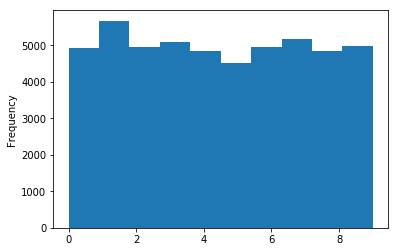

Label: 7


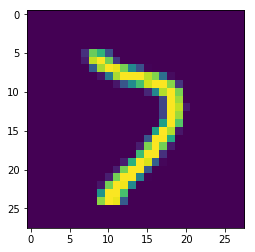

In [121]:
X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('Rows: {}, Columns: {}'.format(X_data.shape[0], X_data.shape[1]))
print('Rows: {}, Columns: {}'.format(X_test.shape[0], X_test.shape[1]))

print('Training:      ', X_train.shape, y_train.shape)
print('Validation:    ', X_valid.shape, y_valid.shape)
print('Test Set:      ', X_test.shape, y_test.shape)

# Test the frequency of the training set to detect if it was necessary to stratify.
x = np.random.randint(1, 100, 5)
plt.hist(np.array(y_train), bins=10)
plt.ylabel('Frequency')
plt.show()

# Test just a random image to see what we are working with:
random_sample = random.randint(0, len(X_test)-1)
label, pixels =  y_train[random_sample], X_train[random_sample]
img = np.array(pixels).reshape((28,28))
print('Label: {}'.format(label))
plt.imshow(img)

# The model design
- Convolutional networks saves memory maintaining exceptional results. As we can observe, we are not passing the full data throught all the network, what makes us saving lots of resources. Instead of that, we reduce the data into smaller covolutional pieces, that contains the main patterns of the image. We create several layers in order to obtain deeper patterns.
- After the convolutional operation we do a pooling, in this case we choose the max value, but there are other options like the average pooling.
- The way to know the output of a convolutional operation, is by the formula Odimension = floor((n + 2*padding - m) / stride), where n is the size of the entry and m of the filter.
- Softmax is again an activation function. In this case is a normalized exponential function.

In [122]:
tensorboard = TensorBoard('./log')

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.fit(X_train, y_train, epochs=5, callbacks=[tensorboard])
model.evaluate(X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                36928     
__________

[0.05686144814963336, 0.9847]

## Test the results with a random image from the test dataset

28
Prediction: 4 - Accuracy 100.0% - Ground Truth 4


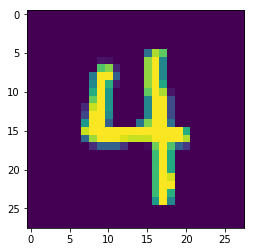

In [123]:
seed = random.randint(0, len(X_test)-1)
size_i = len(X_test[seed])
print(size_i)
test_img = np.array([X_test[seed].reshape((28,28,1))])

predictions = model.predict(test_img)
accuracy = np.amax(predictions) * 100

prediction = np.unravel_index(predictions.argmax(), predictions.shape[1])[0]
print('Prediction: {} - Accuracy {}% - Ground Truth {}'.format(prediction, round(accuracy,2), y_test[seed]))

img = np.array(test_img).reshape((28,28))
plt.imshow(img)

## Plot the results in a confusion matrix
Now if we are interested in knowing the prediction versus the real value of all the test examples, not just a single one as we saw, we can build a confusion matrix to plot them all.
- First we obtain the predictions over the X_test examples.
- Then, we pre-process the results obtained in order to plt the confusion matrix.

In [0]:
y_pred = []

predictions_test = model.predict(X_test)

for prediction in predictions_test:
  y = prediction.argmax()
  y_pred.append(y)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0daaba5fd0>)

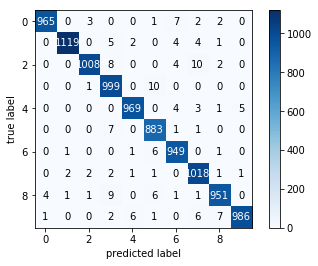

In [125]:
sumarize = {}
for t in range(0, 10):
  sum_pred = {}
  
  for p in range(0, 10):
    sum_pred[p] = 0
  
  sumarize[t] = sum_pred

for i, t in enumerate(y_test):
  sumarize[t][y_pred[i]] = sumarize[t][y_pred[i]] + 1
  

sum_array = []
for label in sumarize.values():
  values = []
  for result in label.values():
    values.append(result)
  sum_array.append(values)

plot_confusion_matrix(conf_mat=np.array(sum_array),
                      show_absolute=True,
                      show_normed=False,
                      colorbar=True)

## Conclusions
- High accuracy and small loss, good symptoms even with small number of epochs. 
- More epochs would deal us to a data memorizing scenario.